# All In One Place

### - O objetivo é determinar quem são os clientes elegíveis para participar de um programa de fidelidade da empresa All In One Place?

#### O conjunto de dados:

- Cada linha representa uma transação de venda, que ocorreu entre o período de Novembro de 2016 e Dezembro de 2017.

>Invoice Number: identificador único de cada transação.\
Stock Code Product: código do item.\
Description Product: nome do item.\
Quantity: A quantidade de cada item comprado por transação.\
Invoice Date: O dia em que a transação ocorreu.\
Unit Price: Preço do produto por unidade.\
Customer ID: identificador único do cliente.\
Country: O nome do país que o cliente reside.

In [125]:
#Pacotes
library(tidyverse)
library(ggplot2)
library(cowplot)
library(repr)
library(lubridate)
library(cluster)
library(dendextend)
library(factoextra)
library(fpc)
library(gridExtra)
library(glue)
library(dbscan)

In [126]:
dados <- read.csv("Ecommerce.csv")
head(dados)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,X
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<chr>,<lgl>
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850,United Kingdom,NA
2,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850,United Kingdom,NA
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850,United Kingdom,NA
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850,United Kingdom,NA
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850,United Kingdom,NA
6,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,29-Nov-16,7.65,17850,United Kingdom,NA


### - Limpeza dos dados

In [127]:
glimpse(dados)

Rows: 541,909
Columns: 9
$ InvoiceNo   <chr> "536365", "536365", "536365", "536365", "536365", "536365"~
$ StockCode   <chr> "85123A", "71053", "84406B", "84029G", "84029E", "22752", ~
$ Description <chr> "WHITE HANGING HEART T-LIGHT HOLDER", "WHITE METAL LANTERN~
$ Quantity    <int> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, 3, ~
$ InvoiceDate <chr> "29-Nov-16", "29-Nov-16", "29-Nov-16", "29-Nov-16", "29-No~
$ UnitPrice   <dbl> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1.69~
$ CustomerID  <int> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17~
$ Country     <chr> "United Kingdom", "United Kingdom", "United Kingdom", "Uni~
$ X           <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA~


- Temos 541909 observações e 9 variáveis.
- A variável "X" possui apenas valores faltantes
- A variável "InvoiceDate" é do tipo chr, este deveria estar no formato date

In [128]:
#Transformando "InvoiceDate" para o formato date e eliminando a coluna de valores faltantes "X"
dados$X <- NULL
dados$InvoiceDate <- dmy(dados$InvoiceDate)

In [129]:
glimpse(dados)

Rows: 541,909
Columns: 8
$ InvoiceNo   <chr> "536365", "536365", "536365", "536365", "536365", "536365"~
$ StockCode   <chr> "85123A", "71053", "84406B", "84029G", "84029E", "22752", ~
$ Description <chr> "WHITE HANGING HEART T-LIGHT HOLDER", "WHITE METAL LANTERN~
$ Quantity    <int> 6, 6, 8, 6, 6, 2, 6, 6, 6, 32, 6, 6, 8, 6, 6, 3, 2, 3, 3, ~
$ InvoiceDate <date> 2016-11-29, 2016-11-29, 2016-11-29, 2016-11-29, 2016-11-2~
$ UnitPrice   <dbl> 2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85, 1.69~
$ CustomerID  <int> 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17~
$ Country     <chr> "United Kingdom", "United Kingdom", "United Kingdom", "Uni~


In [130]:
summary(dados)

  InvoiceNo          StockCode         Description           Quantity        
 Length:541909      Length:541909      Length:541909      Min.   :-80995.00  
 Class :character   Class :character   Class :character   1st Qu.:     1.00  
 Mode  :character   Mode  :character   Mode  :character   Median :     3.00  
                                                          Mean   :     9.55  
                                                          3rd Qu.:    10.00  
                                                          Max.   : 80995.00  
                                                                             
  InvoiceDate           UnitPrice           CustomerID       Country         
 Min.   :2016-11-29   Min.   :-11062.06   Min.   :12346    Length:541909     
 1st Qu.:2017-03-26   1st Qu.:     1.25   1st Qu.:13953    Class :character  
 Median :2017-07-17   Median :     2.08   Median :15152    Mode  :character  
 Mean   :2017-07-02   Mean   :     4.61   Mean   :15288         

 - Existem 135080 registros não informados de clientes (CustumerID). Estes registros não podem ser usados na nossa análise pois não sabemos quem são estes clientes.

In [131]:
dados <- dados[!is.na(dados$CustomerID),]
dim(dados)

[1] 406829      8

In [132]:
#Criando a coluna "ValorTotal":
dados$ValorTotal <- dados$UnitPrice * dados$Quantity

In [133]:
summary(dados)

  InvoiceNo          StockCode         Description           Quantity        
 Length:406829      Length:406829      Length:406829      Min.   :-80995.00  
 Class :character   Class :character   Class :character   1st Qu.:     2.00  
 Mode  :character   Mode  :character   Mode  :character   Median :     5.00  
                                                          Mean   :    12.06  
                                                          3rd Qu.:    12.00  
                                                          Max.   : 80995.00  
  InvoiceDate           UnitPrice          CustomerID      Country         
 Min.   :2016-11-29   Min.   :    0.00   Min.   :12346   Length:406829     
 1st Qu.:2017-04-04   1st Qu.:    1.25   1st Qu.:13953   Class :character  
 Median :2017-07-29   Median :    1.95   Median :15152   Mode  :character  
 Mean   :2017-07-08   Mean   :    3.46   Mean   :15288                     
 3rd Qu.:2017-10-18   3rd Qu.:    3.75   3rd Qu.:16791                    

In [134]:
#Eliminando valores totais negativos:
dados <- dados[dados$ValorTotal > 0,]
head(dados)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ValorTotal
,<chr>,<chr>,<chr>,<int>,<date>,<dbl>,<int>,<chr>,<dbl>
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30
2,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34
5,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34
6,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2016-11-29,7.65,17850,United Kingdom,15.30


In [135]:
dim(dados)

[1] 397884      9

- Agora estamos com a base de dados na forma ideal para uma análise mais aprofundada.

## - Clusterização

### - Preparando os dados

> Como queremos encontrar os clientes que mais gastam e que compram a maior quantidade de produtos, vamos usar apenas as variáveis "Quantity" e "UnitPrice" (como a variável "ValorTotal" tem muita relação com as escolhidades, inicialmente, ela não é necessária para a análise).

In [136]:
dados_cluster <- dados %>% 
                 select("CustomerID", "Quantity", "UnitPrice") %>% 
                 group_by(CustomerID) %>% 
                 summarise(Quantidade = sum(Quantity), ValorGasto = sum(UnitPrice))
head(dados_cluster, 5)

CustomerID,Quantidade,ValorGasto
<int>,<int>,<dbl>
12346,74215,1.04
12347,2458,481.21
12348,2341,178.71
12349,631,605.10
12350,197,65.30


In [137]:
dados_cluster <- column_to_rownames(dados_cluster, "CustomerID")

In [138]:
dados_cluster_padr <- scale(dados_cluster)
head(dados_cluster_padr)

,Quantidade,ValorGasto
12346,14.4713696,-0.3234094
12347,0.2510286,0.2218439
12348,0.2278423,-0.1216576
12349,-0.1110345,0.3625262
12350,-0.1970418,-0.2504395
12352,-0.1298610,1.2130587


- Iniciaremos a análise testando o método baseado em centróides, k-means

### K-Means

- Para este método, inicialmente, precisamos escolher o número de clusters que devem ser construídos. Para isso vamos usar dois métodos, wss (soma de quadrados ou elbow) e silhueta.

In [139]:
vizwss_km <- fviz_nbclust(dados_cluster_padr, FUN = kmeans, method = "wss") +
labs(title = "Número de cluster pelo método WSS",
     x = "Númerod de clusters",
     y = "Soma dos quadrados")
vizsil_km <- fviz_nbclust(dados_cluster_padr, FUN = kmeans, method = "silhouette") +
labs(title = "Número de cluster pelo método Silhueta",
     x = "Númerod de clusters",
     y = "Silhueta")

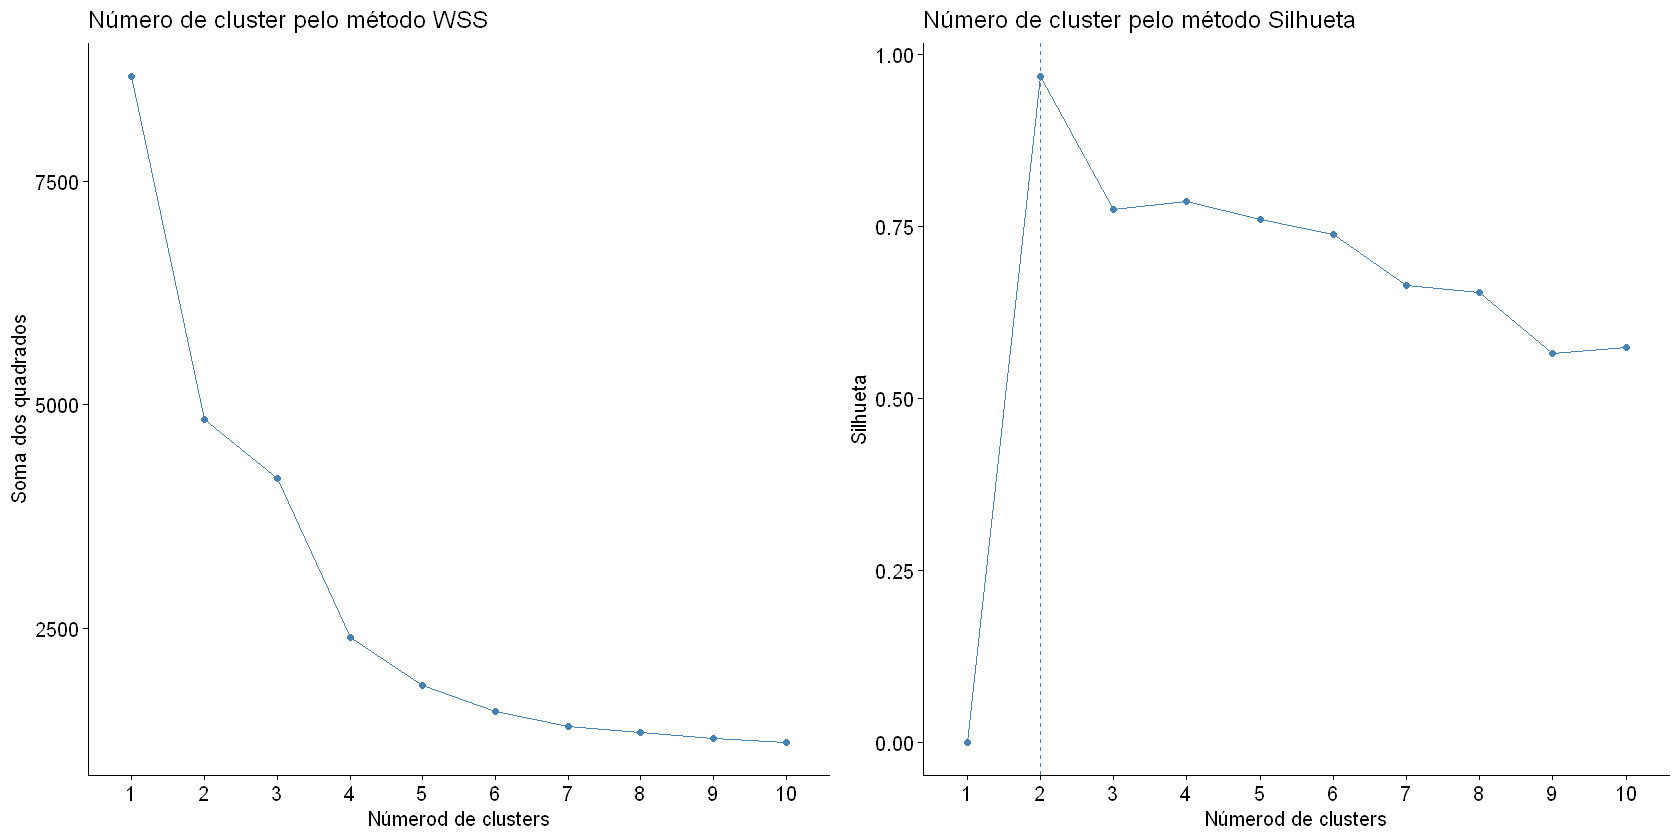

In [140]:
options(repr.plot.width = 14, repr.plot.height = 7)
plot_grid(vizwss_km, vizsil_km)

- Pelo método soma de quadrados (wss) o valor ideal de clusters parece ser 4, pois é nesse ponto que a variabilidade começa a diminuir de fato. Ja pelo método da silhueta o número ideal de clusters é 2. Vamos testar as duas opções.

In [141]:
set.seed(101)
k2 <- kmeans(dados_cluster_padr, centers = 2)
k4 <- kmeans(dados_cluster_padr, centers = 4)

In [142]:
vizk2 <- fviz_cluster(k2, geom = "point", data = dados_cluster_padr)
vizk4 <- fviz_cluster(k4, geom = "point", data = dados_cluster_padr)

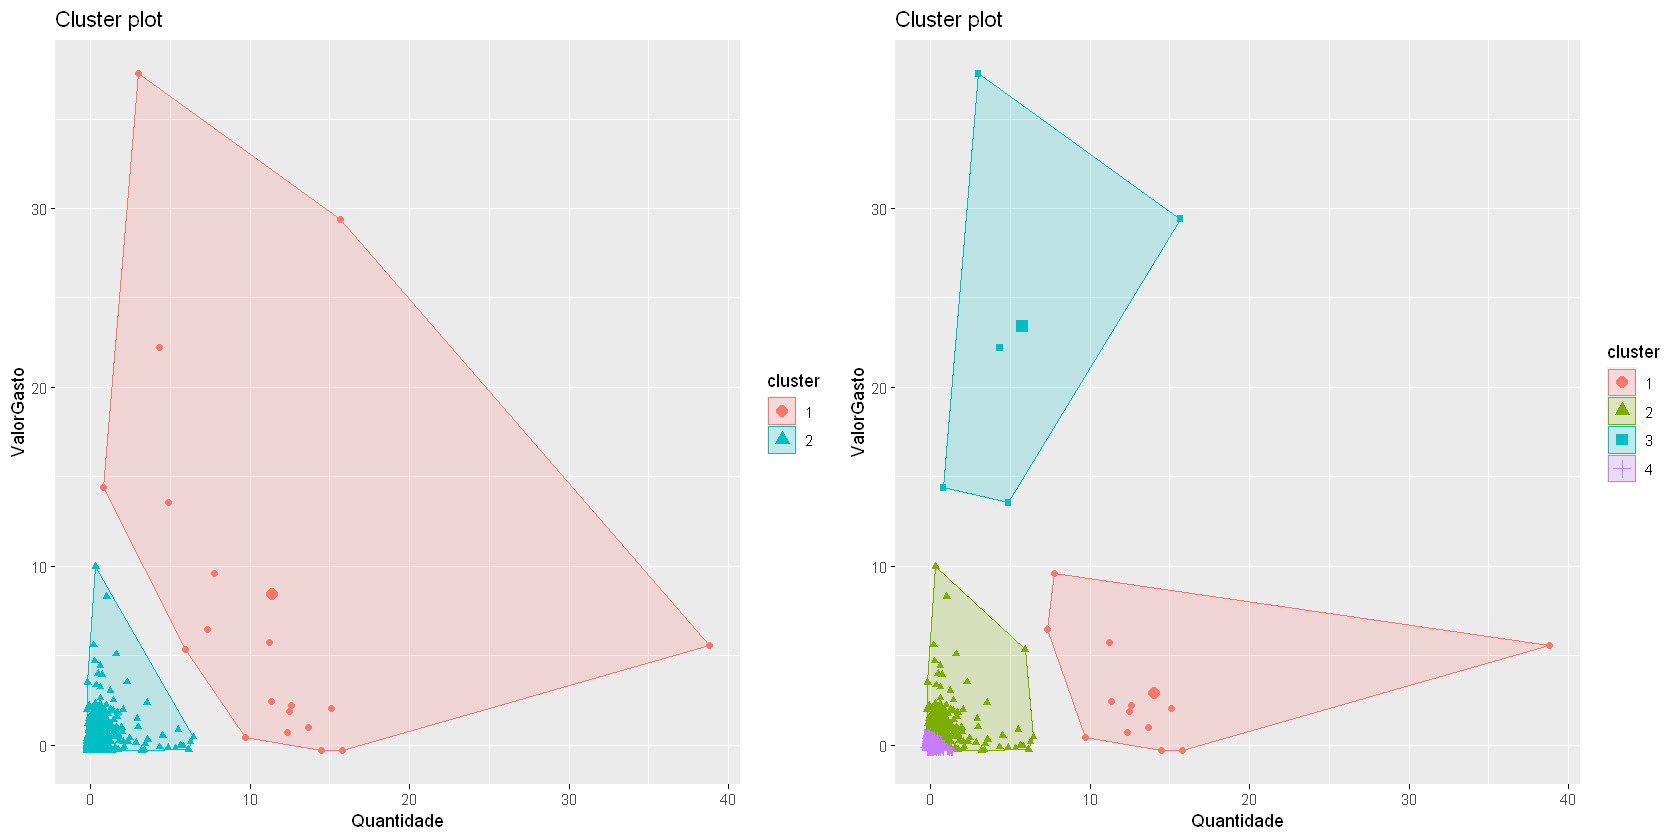

In [143]:
options(repr.plot.width = 14, repr.plot.height = 7)
plot_grid(vizk2, vizk4)

- Na abordagem em que utilizamos o modelo com 2 centros o cluster 1 é o que contém os clientes de nosso interesse. Na abordagem com 4 centros o cluster 1 é o que contém os clientes que compraram as maiores quantidades de produtos e no cluster 3 os clientes que mais gastaram. Porém, os clientes do cluster 2 no primeiro modelo correspondem aos mesmo do cluster 1 e 3 do segundo modelo. Sendo assim, vamos analisar somente o modelo com 2 centros.

In [144]:
cluster_k2 <- data.frame(k2$cluster)
dados_k2 <- cbind(dados_cluster, cluster_k2)

### - Analizando os clusters

#### - Cluster com 2 centros

> Vamos selecionar, para a análise, o cluster 1

In [145]:
cluster1_k2 <- dados_k2[dados_k2$k2.cluster == 1,]
cluster1_k2$k2.cluster <- NULL
cluster1_k2$ValorTotal  <- cluster1_k2$Quantidade * cluster1_k2$ValorGasto

In [146]:
dados_k2$ValorTotal <- dados_k2$Quantidade * dados_k2$ValorGasto
head(dados_k2, 5)

,Quantidade,ValorGasto,k2.cluster,ValorTotal
,<int>,<dbl>,<int>,<dbl>
12346,74215,1.04,1,77183.6
12347,2458,481.21,2,1182814.2
12348,2341,178.71,2,418360.1
12349,631,605.10,2,381818.1
12350,197,65.30,2,12864.1


In [147]:
head(cluster1_k2, 5)

,Quantidade,ValorGasto,ValorTotal
,<int>,<dbl>,<dbl>
12346,74215,1.04,77183.6
12415,77374,2097.08,162259467.9
12744,5241,12949.99,67870897.6
12748,25747,12205.60,314257583.2
13089,31070,4977.35,154646264.5


In [148]:
glue(" - Número de clientes selecionados: {nrow(cluster1_k2)}")
glue(" - Porcentagem de clientes selecionados: {round(nrow(cluster1_k2)/nrow(dados_k2)*100, 2)} %")

- Número de clientes selecionados: 19

- Porcentagem de clientes selecionados: 0.44 %

In [149]:
glue(" - Porcentagem de produtos comprados pelos clientes selecionados: {round(sum(cluster1_k2$Quantidade)/sum(dados_k2$Quantidade)*100, 2)} %")
glue(" - Porcentagem de gasto dos clientes selecionados: {round(sum(cluster1_k2$ValorTotal)/sum(dados_k2$ValorTotal)*100, 2)} %")

- Porcentagem de produtos comprados pelos clientes selecionados: 21.64 %

- Porcentagem de gasto dos clientes selecionados: 72.63 %

> Com o modelo de clusterização k-means conseguimos um ótimo resultado, com apenas 0,44% dos clientes conseguimos selecionar 72,63% do ganho total da empresa. 

- Vamos testar agora um método baseado na densidade dos dados, DBSCAN (Density-Based Spatial Clustering of Applications with Noise).

## DBSCAN

 - Para métodos baseados em densidade não precisamos selecionar o número de clusters previamente. Porém, precisamos decidir o valor de eps que é a distância mínima (raio) entre os pontos da vizinhança e o MinPts que é o número de pontos mínimos exigidos na vizinhança de eps para pontos centrais.
 
 - Para estimar o valor ideal de eps vamos utilizar o calculo dos k vizinhos próximos, KNN. Queremos encontrar o ponto onde a curva suavisa.

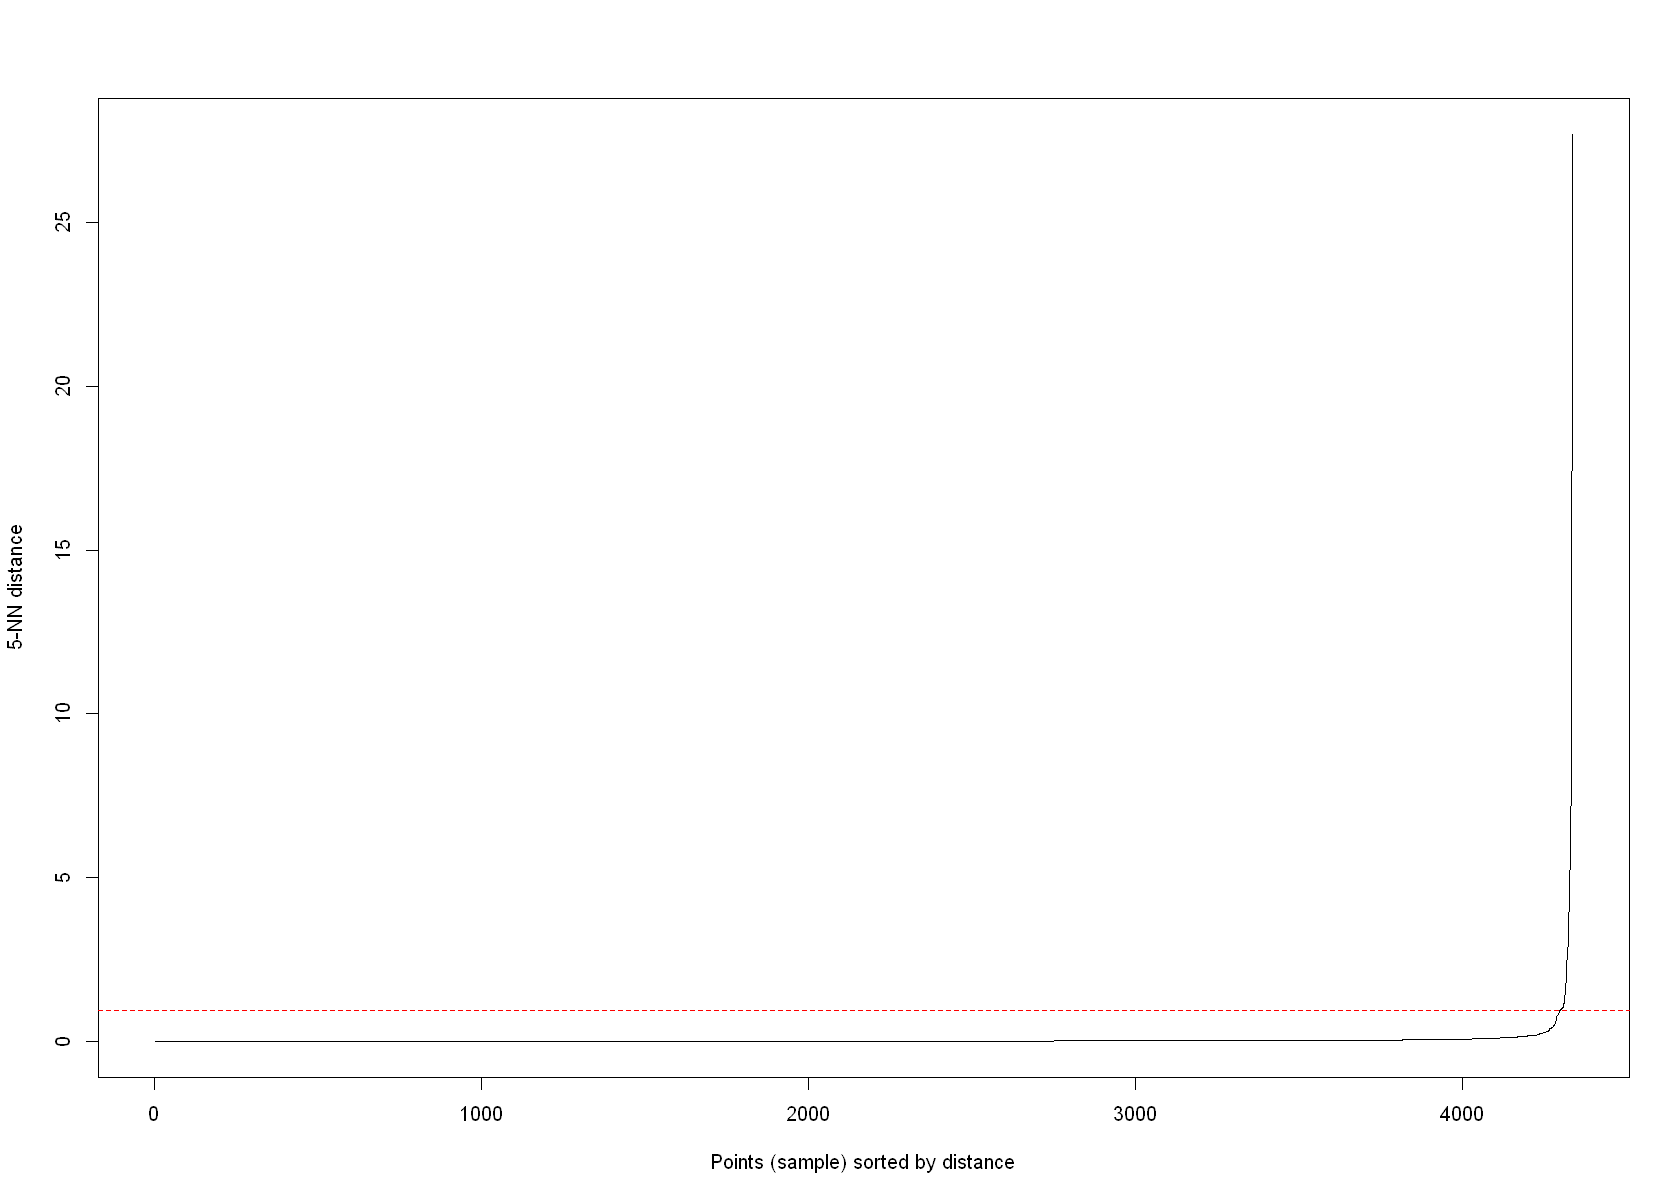

In [150]:
options(repr.plot.width = 14, repr.plot.height = 10)
kNNdistplot(x = dados_cluster_padr, k = 5)
abline(h = 0.95, col = "red", lty = 2)

In [151]:
set.seed(101)
cluster_dbscan <- fpc::dbscan(dados_cluster_padr, eps = 0.95, MinPts = 5)

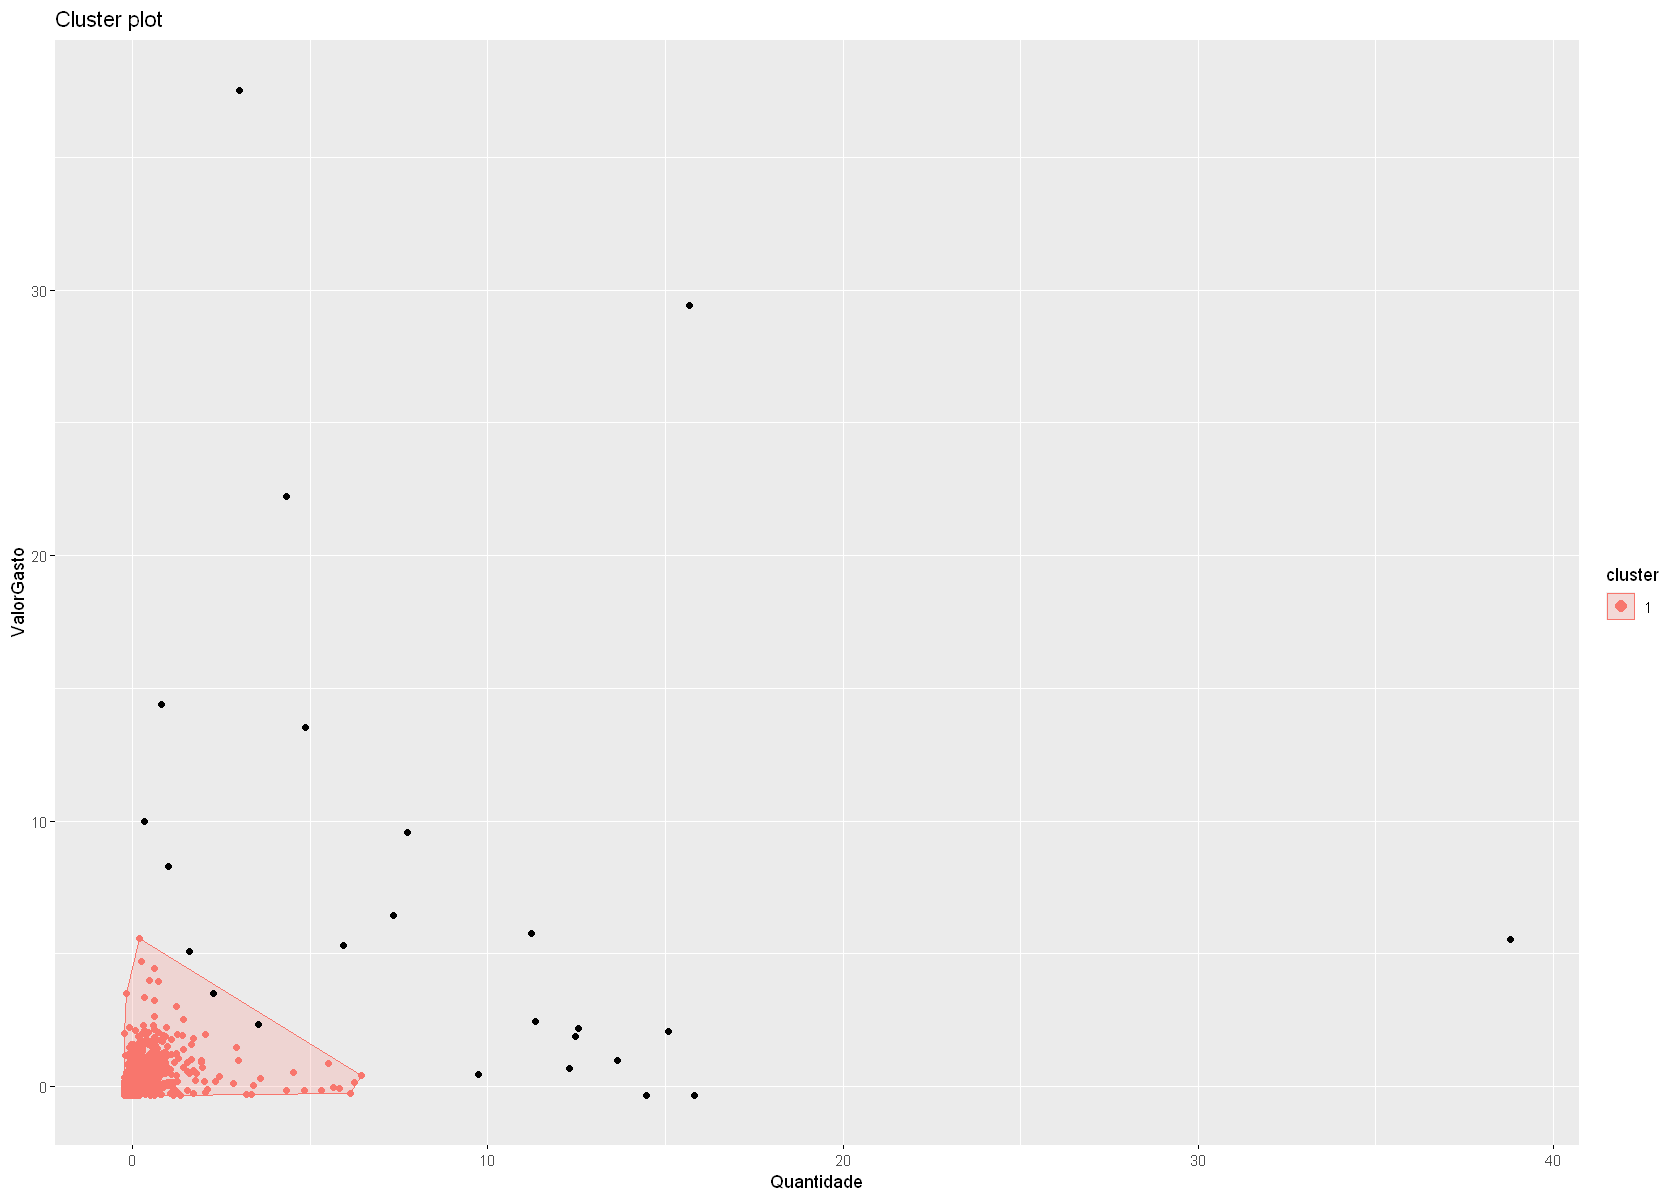

In [152]:
fviz_cluster(cluster_dbscan, geom = "point", data = dados_cluster_padr)

- O método DBSCAN selecionou um cluster, exatamente a parte mais densa dos dados, os outros dados foram colocados como outliers. Os dados colocados como outliers são são os clientes que nos interessam, isto é, os clientes que mais gastaram e que mais compraram produtos. Como neste método só temos um cluster e os outliers são, quase exatamente,  os mesmos que selecionamos no método k-mean, não vale a pena continuar com a análise do presente método.

- Por fim, vamos testar um método de clusterização por conectividade, clusteriação hierárquica.

## - Cluster Hierárquico

- Nós temos muitos dados na nossa base, isso dificulta a visualização dos dendogramas do método hieráquico. Mas podemos testar este método e tentar escolher um número pequeno de clusters, isso é, podemos escolher o corte para a formação dos clusters na parte mais visível do dendograma.

- Para a construção do dendograma vamos escolher a medida euclidiana e o método de Ward. Pois, como já vimos em um gráfico de Quantidade X Valor Gasto por cliente, temos uma quantidade muito grande de dados e estes dados estão muito próximos em certas partes, logo esta escolha resultará em um boa visialização.

In [153]:
distancia <- dist(x = dados_cluster_padr, method = "euclidean")
hc <- hclust(d = distancia, method = 'ward.D')

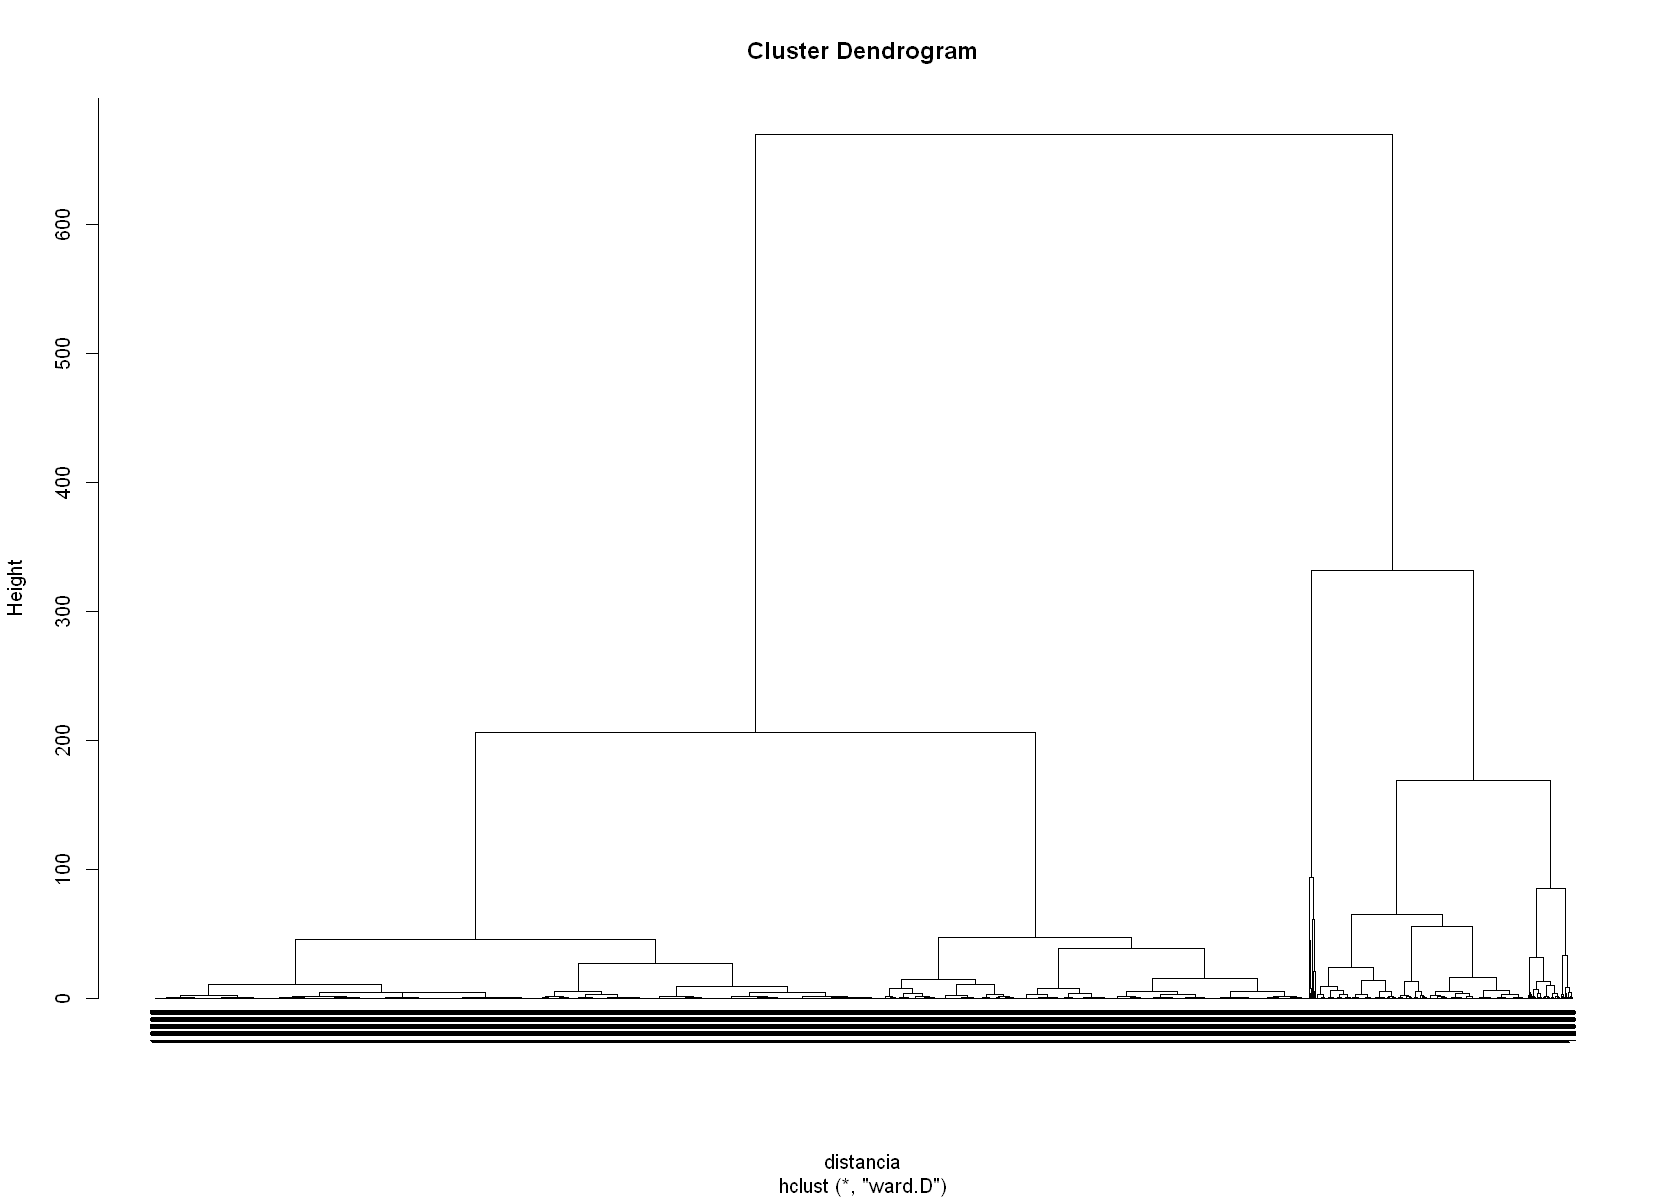

In [154]:
plot(hc, cex = 0.6, hang = -1)

- 2 é um bom número de clusters para escolhermos, pois é nesse ponto que as distâncias entre os clusters anteriores ficam maiores. Vamos observar este corte.

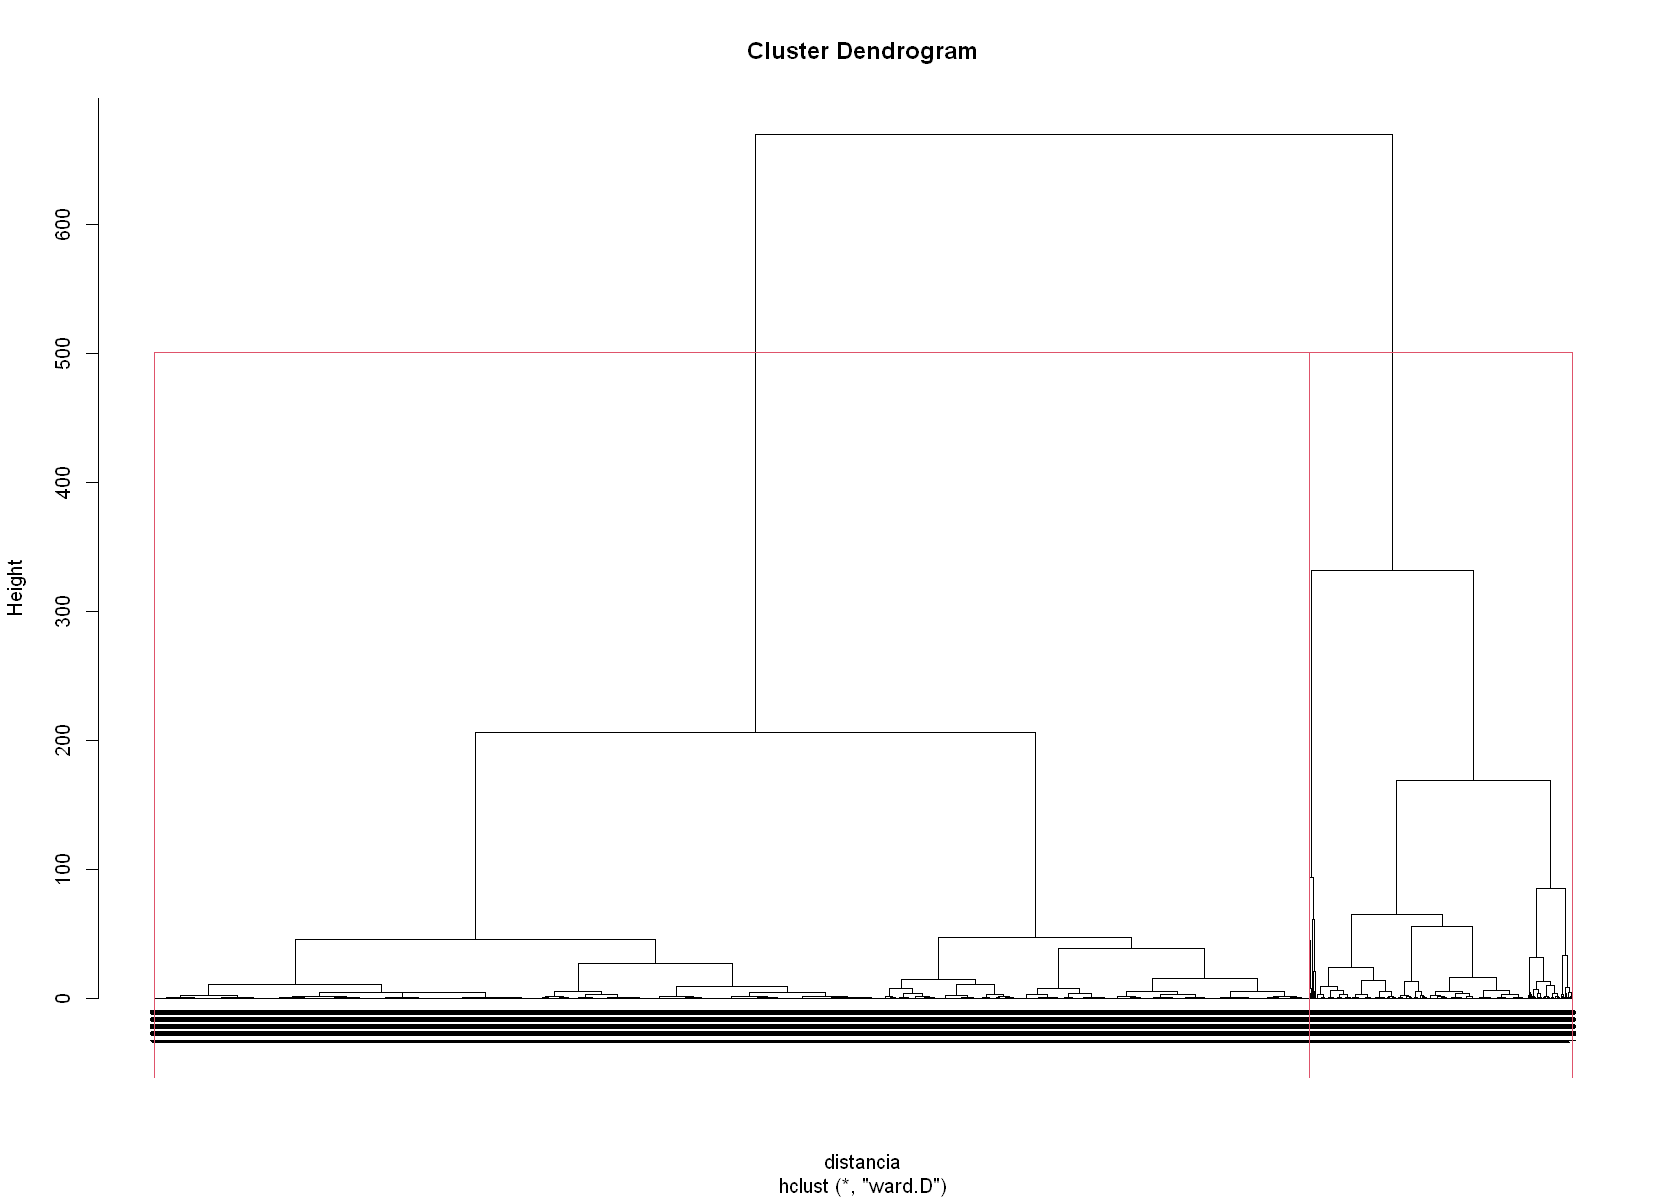

In [155]:
plot(hc, cex = 0.6, hang = -1)
rect.hclust(hc, k = 2)

In [156]:
#Preparando os clusters
hierarquico <- cutree(hc, k = 2)
cluster_hierarquico <- cbind(dados_cluster, hierarquico)
head(cluster_hierarquico)

,Quantidade,ValorGasto,hierarquico
,<int>,<dbl>,<int>
12346,74215,1.04,1
12347,2458,481.21,1
12348,2341,178.71,2
12349,631,605.10,1
12350,197,65.30,2
12352,536,1354.11,1


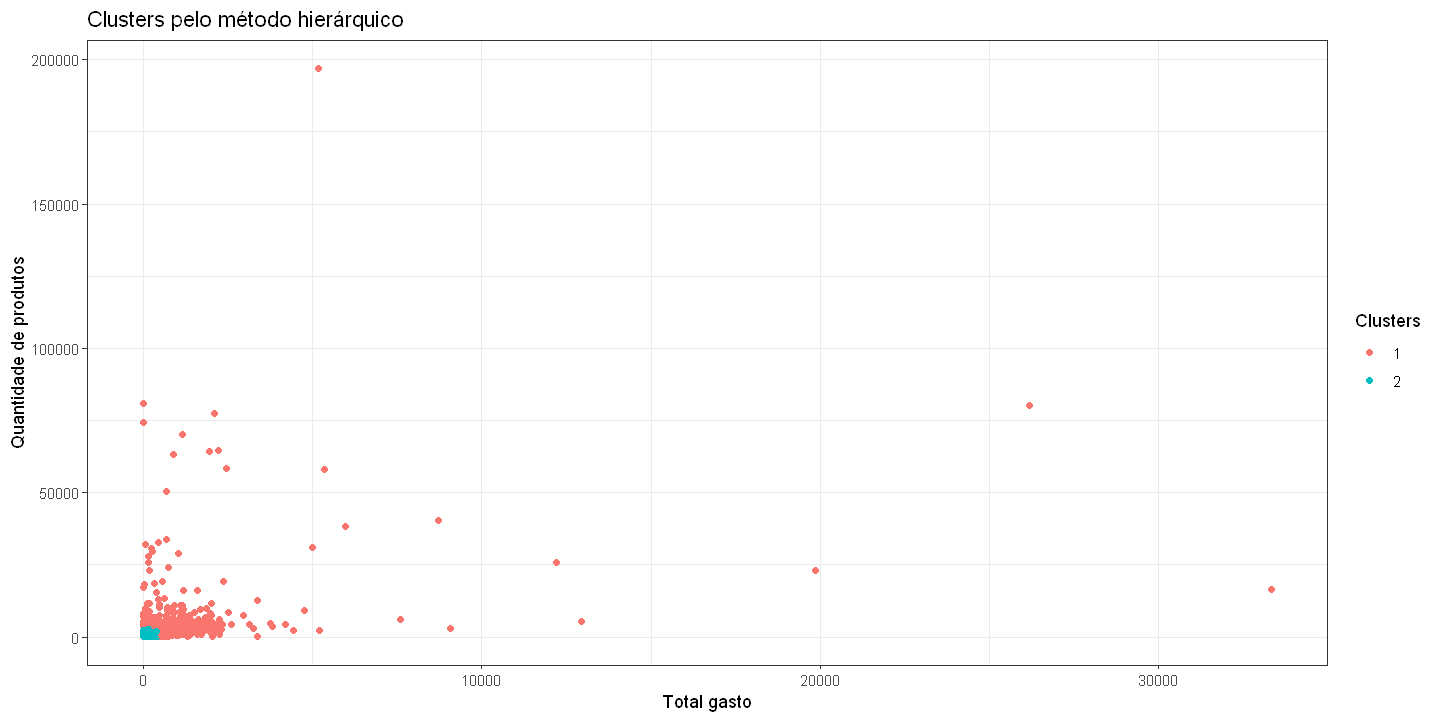

In [157]:
#Observando os elementos dos clusters
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(cluster_hierarquico) +
  geom_point(mapping = aes(x = ValorGasto, y = Quantidade,
                           color = as.factor(hierarquico))) +
  labs(title = "Clusters pelo método hierárquico",
       x = "Total gasto",
       y = "Quantidade de produtos",
       color = "Clusters") +
  theme_bw()

- Os clientes que mais gastaram e que compraram mais produtos estão no cluster 1. Vamos selecioná-lo para compararmos com o total.

In [158]:
clusterh1 <- cluster_hierarquico[cluster_hierarquico$hierarquico == 1,]
clusterh1$hierarquico <- NULL
clusterh1$ValorTotal <- clusterh1$Quantidade * clusterh1$ValorGasto
head(clusterh1)

,Quantidade,ValorGasto,ValorTotal
,<int>,<dbl>,<dbl>
12346,74215,1.04,77183.6
12347,2458,481.21,1182814.2
12349,631,605.10,381818.1
12352,536,1354.11,725803.0
12357,2708,438.67,1187918.4
12359,1622,2137.86,3467608.9


In [159]:
cluster_hierarquico$ValorTotal <- cluster_hierarquico$Quantidade * cluster_hierarquico$ValorGasto
head(cluster_hierarquico)

,Quantidade,ValorGasto,hierarquico,ValorTotal
,<int>,<dbl>,<int>,<dbl>
12346,74215,1.04,1,77183.6
12347,2458,481.21,1,1182814.2
12348,2341,178.71,2,418360.1
12349,631,605.10,1,381818.1
12350,197,65.30,2,12864.1
12352,536,1354.11,1,725803.0


In [160]:
glue(" - Número de clientes selecionados: {nrow(clusterh1)}")
glue(" - Porcentagem de clientes selecionados: {round(nrow(clusterh1)/nrow(cluster_hierarquico)*100, 2)} %")

- Número de clientes selecionados: 807

- Porcentagem de clientes selecionados: 18.6 %

In [161]:
glue(" - Porcentagem de produtos comprados pelos clientes selecionados: {round(sum(clusterh1$Quantidade)/sum(cluster_hierarquico$Quantidade)*100, 2)} %")
glue(" - Porcentagem de gasto dos clientes selecionados: {round(sum(clusterh1$ValorTotal)/sum(cluster_hierarquico$ValorTotal)*100, 2)} %")

- Porcentagem de produtos comprados pelos clientes selecionados: 68.7 %

- Porcentagem de gasto dos clientes selecionados: 96.77 %

# -----------------------------------------------------------------------------------------------------------------

# - Sumarizando

- O método de clusterização baseado em densidade, DBSCAN, não se mostrou um bom método para o nosso propósito. Ele selecionou a parte mais densa da nossa base de dados, que eram os clientes que menos gastavam e menos compravam na empresa All In One Place e colocou os outros clientes como outliers. Por este motivo decidimos descartar a análise por este método.

- Para a utilização do método k-means, que é um método baseado em centróides, utilizamos o método da silhueta e o método elbow para encontrarmos o número ideal de clusters. O método da silhueta indicou que o deveríamos selecionar 2 clusters e o método elbow indicou que poderiam ser 2 ou 4 clusters. Após uma análise visual decidimos que o ideal seriam 2 clusters. Analisando os dois clusters selecionados escolhemos aquele de nosso interesse. Verificamos que, para nosso propósito, foram selecionados 19 clientes, o correspondente a  0.44 % da base de dados e que esses clientes foram responsáveis por 21.64% dos produtos comprados e por 72.63% do dinheiro gasto na loja.

- Para o método de clusterização hierárquico construimos um dendograma utilizando a distância euclidiana e o método de aglomeração de Ward, isto levando em conta a quantidade e a aproximação entre os dados em um gráfico de Quantidade X Valor Gasto por cliente. Tendo a visualização do dendograma, pelas distâncias das formações dos clusters, optamos por separar a base em dois clusters. Analisando os clusters formados escolhemos o cluster de nosso interesse. O método hieráquico selecionou 807 clientes, o que corresponde a 18.6% do total, estes clientes foram responsáveis pela compra de 68.7% dos produtos e por 96.77% do dinheiro gasto na empresa.

## - Concluindo

- Fica indicado para o programa de fidelidade os clientes selecionados pelo método hieráquico, pois, neste caso temos uma boa porcentagem dos clientes 18.6%. O método k-means selecionou apenas 0.44% dos clientes, não vale a pena para a empresa investir em um programa de fidelidade para atingir tão poucos clientes e outos clientes que verão poucos selecionados não se sentirão incentivados a se esforçar para entrar no programa. Além disso o cluster hieráquico selecionou os clientes responsáveis por 96,77% dos ganho da empresa, de fato esses clientes merecem estar em um programa de fidelidade. 


- É importante pontuar que, para inserir novos clientes no programa de fidelidade, é necessário repetir o processo de clusterização já que este é um modelo de machine learning não supervisionado e, sendo assim, não permite inferências para clientes futuros.